In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Signal Processing & Stats
from scipy.signal import butter, sosfiltfilt
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve)
from sklearn.impute import SimpleImputer

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Error: imbalanced-learn library not found. Please install it: pip install imbalanced-learn")
    exit()

#File used is Main_ML_forge.csv

In [2]:
CSV_FILE_PATH = '/content/drive/MyDrive/Data_fold/Main_ML_forge.csv'
TARGET_STATE = 13                    # State representing the 'Undamaged' condition
FS = 322.58                          # Sampling frequency in Hz
FILTER_LOWCUT = 18.0                 # Low cutoff frequency for bandpass filter
FILTER_HIGHCUT = 160.0               # High cutoff frequency for bandpass filter
FILTER_ORDER = 5                     # Filter order
TEST_SIZE = 0.3                      # Proportion of data to use for the test set
RANDOM_STATE = 42                    # Random seed for reproducibility
RF_N_ESTIMATORS = 100

In [3]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """Prints evaluation metrics and plots confusion matrix."""
    print(f"\n--- Evaluation: {model_name} ---")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    target_names = ['Undamaged (State 13)', 'Damaged (Other States)']
    print("\nClassification Report:")
    try:
        # Use zero_division=0 to avoid warnings when a class has no predictions
        print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    except Exception as e:
        print(f"Could not generate classification report: {e}")

    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    except ValueError as e:
        print(f"Could not calculate ROC AUC score: {e} (Might occur if only one class in y_true or all probabilities are identical)")
    except Exception as e:
         print(f"An unexpected error occurred calculating ROC AUC: {e}")


    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # Ensure labels are [0, 1]
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")

# --- 1. Data Loading ---
print(f"Loading data from: {CSV_FILE_PATH}")

Loading data from: /content/drive/MyDrive/Data_fold/Main_ML_forge.csv


In [4]:
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print("Data loaded successfully.")
    print(df.head())
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

Data loaded successfully.
   State     Force      acc1      acc2      acc3      acc4    Time
0      1  15.66710  0.435170  0.041358 -0.179954  0.049033  0.0000
1      1  12.42760 -0.030668  0.096704  0.786429 -0.666803  0.0031
2      1  19.51020 -0.238181  0.400636  0.713335 -0.714454  0.0062
3      1  -1.35914 -0.412437  0.554442 -0.207911 -0.118673  0.0093
4      1 -16.37290  0.024085 -0.012602 -0.730537  0.469126  0.0124


In [5]:
expected_cols = ['State', 'Force', 'acc1', 'acc2', 'acc3', 'acc4', 'Time']
if not all(col in df.columns for col in expected_cols):
    print(f"Error: CSV is missing one or more expected columns: {expected_cols}")
    print(f"Found columns: {df.columns.tolist()}")
    exit()

In [6]:
print("\nIdentifying individual measurement instances based on Time reset...")
# Create a unique ID for each measurement block where Time resets
df['measurement_id'] = (df['Time'].diff().fillna(0) < 0).cumsum()
num_measurements = df['measurement_id'].nunique()
print(f"Identified {num_measurements} distinct measurement instances.")
print("Sample points per measurement:")
print(df.groupby('measurement_id').size().head())


Identifying individual measurement instances based on Time reset...
Identified 169 distinct measurement instances.
Sample points per measurement:
measurement_id
0    8192
1    8192
2    8192
3    8192
4    8192
dtype: int64


In [7]:
# --- 3. Target Variable Creation ---
print("\nCreating target variable (0=Undamaged, 1=Damaged)...")
measurement_info = df.groupby('measurement_id').agg(
    State=('State', 'first'),
    NumPoints=('Time', 'count')
).reset_index()


Creating target variable (0=Undamaged, 1=Damaged)...


#Signal processing

In [8]:
# Create the binary target variable
measurement_info['Damage_Label'] = measurement_info['State'].apply(lambda x: 0 if x == TARGET_STATE else 1)
print("Target variable created. Distribution:")
print(measurement_info['Damage_Label'].value_counts(normalize=True))

# --- 4. Signal Preprocessing (Filtering) ---
print(f"\nApplying band-pass filter ({FILTER_LOWCUT}-{FILTER_HIGHCUT} Hz)...")

# Design the filter (Butterworth bandpass)
sos = butter(FILTER_ORDER, [FILTER_LOWCUT, FILTER_HIGHCUT], btype='band', output='sos', fs=FS)

Target variable created. Distribution:
Damage_Label
1    0.946746
0    0.053254
Name: proportion, dtype: float64

Applying band-pass filter (18.0-160.0 Hz)...


In [9]:
# Function to apply filter to a group (one measurement)
def apply_filter_to_group(group, channels_to_filter, sos_filter, filter_order):
    group = group.copy()
    min_len = 3 * (filter_order + 1) # Rule of thumb, sosfiltfilt stability
    for col in channels_to_filter:
        signal = group[col].values
        if len(signal) > min_len:
            try:
                group[col] = sosfiltfilt(sos_filter, signal)
            except Exception as e:
                 print(f"Warning: Filtering failed for measurement_id {group['measurement_id'].iloc[0]}, column {col}. Error: {e}. Keeping original.")
        else:
            print(f"Warning: Signal too short ({len(signal)} points) for filtering in measurement_id {group['measurement_id'].iloc[0]}, column {col}. Keeping original.")
    return group

In [10]:
# Apply the filter to relevant channels
channels_to_process = ['Force', 'acc1', 'acc2', 'acc3', 'acc4']
df_filtered = df.groupby('measurement_id', group_keys=False).apply(
    apply_filter_to_group,
    channels_to_filter=channels_to_process,
    sos_filter=sos,
    filter_order=FILTER_ORDER
)
print("Filtering complete.")

# --- 5. Feature Extraction ---
print("\nExtracting features from each measurement...")

Filtering complete.

Extracting features from each measurement...


<ipython-input-10-50f36943bf5f>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby('measurement_id', group_keys=False).apply(


In [11]:
def extract_features(group, channels, fs):
    """Extracts time and frequency domain features from a measurement group."""
    features = {}
    n_points = len(group)
    if n_points <= 1: return pd.Series(features) # Handle empty or single-point groups

    # Estimate time step, fallback to 1/fs if needed
    time_values = group['Time'].values
    dt = np.mean(np.diff(time_values)) if n_points > 1 else 1/fs
    if dt <= 0 or np.isnan(dt): dt = 1/fs # Fallback if dt is invalid

    for col in channels:
        signal = group[col].values

        # Time Domain Stats
        features[f'{col}_mean'] = np.mean(signal)
        features[f'{col}_std'] = np.std(signal)
        rms = np.sqrt(np.mean(signal**2))
        features[f'{col}_rms'] = rms
        peak = np.max(np.abs(signal)) if len(signal) > 0 else 0
        features[f'{col}_peak'] = peak
        features[f'{col}_skew'] = skew(signal)
        features[f'{col}_kurtosis'] = kurtosis(signal)
        features[f'{col}_crest_factor'] = peak / rms if rms > 1e-9 else 0

        # Frequency Domain Stats (using rfft)
        if n_points > 1:
            try:
                yf = rfft(signal)
                xf = rfftfreq(n_points, dt) # Use average dt

                yf_abs = np.abs(yf)

                # Ensure positive frequencies and matching lengths
                valid_indices = (xf >= 0) & (np.arange(len(xf)) < len(yf_abs))
                xf = xf[valid_indices]
                yf_abs = yf_abs[valid_indices]

                if len(xf) > 0:
                    # Peak frequency and amplitude
                    peak_freq_index = np.argmax(yf_abs)
                    features[f'{col}_fft_peak_freq'] = xf[peak_freq_index]
                    features[f'{col}_fft_peak_amp'] = yf_abs[peak_freq_index]

                    # Spectral Centroid
                    sum_yf_abs = np.sum(yf_abs)
                    features[f'{col}_fft_centroid'] = np.sum(xf * yf_abs) / sum_yf_abs if sum_yf_abs > 1e-9 else 0

                    # Energy in bands (example bands)
                    band1_indices = (xf >= 20) & (xf < 50)
                    features[f'{col}_fft_energy_20_50Hz'] = np.sum(yf_abs[band1_indices]**2) / n_points if n_points > 0 else 0
                    band2_indices = (xf >= 50) & (xf < 100)
                    features[f'{col}_fft_energy_50_100Hz'] = np.sum(yf_abs[band2_indices]**2) / n_points if n_points > 0 else 0
                    band3_indices = (xf >= 100) & (xf < 150)
                    features[f'{col}_fft_energy_100_150Hz'] = np.sum(yf_abs[band3_indices]**2) / n_points if n_points > 0 else 0
                else: # Handle cases where no valid frequency data exists
                     features[f'{col}_fft_peak_freq'] = np.nan
                     features[f'{col}_fft_peak_amp'] = np.nan
                     features[f'{col}_fft_centroid'] = np.nan
                     features[f'{col}_fft_energy_20_50Hz'] = np.nan
                     features[f'{col}_fft_energy_50_100Hz'] = np.nan
                     features[f'{col}_fft_energy_100_150Hz'] = np.nan

            except Exception as e:
                print(f"Warning: FFT calculation failed for measurement_id {group['measurement_id'].iloc[0]}, column {col}. Error: {e}. Filling with NaN.")
                features[f'{col}_fft_peak_freq'] = np.nan
                features[f'{col}_fft_peak_amp'] = np.nan
                features[f'{col}_fft_centroid'] = np.nan
                features[f'{col}_fft_energy_20_50Hz'] = np.nan
                features[f'{col}_fft_energy_50_100Hz'] = np.nan
                features[f'{col}_fft_energy_100_150Hz'] = np.nan

    return pd.Series(features)

In [12]:
# Apply feature extraction
feature_df = df_filtered.groupby('measurement_id').apply(extract_features, channels=channels_to_process, fs=FS)
print("Feature extraction complete.")

# Merge features with labels
final_df = pd.merge(feature_df.reset_index(), measurement_info[['measurement_id', 'Damage_Label']], on='measurement_id')
print("Final feature DataFrame with labels:")
print(final_df.head())
print(f"Shape of final feature DataFrame: {final_df.shape}")

# --- 6. Define Features (X) and Target (y) ---
X = final_df.drop(['measurement_id', 'Damage_Label'], axis=1)
y = final_df['Damage_Label']

print(f"\nFeatures (X) shape before split: {X.shape}")
print(f"Target (y) shape before split: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# --- 7. Train/Test Split ---
print(f"\nSplitting data into Train/Test sets (Test size: {TEST_SIZE:.0%})...")

Feature extraction complete.
Final feature DataFrame with labels:
   measurement_id  Force_mean  Force_std  Force_rms  Force_peak  Force_skew  \
0               0    0.003443  20.698470  20.698470   76.469802    0.030385   
1               1    0.003782  20.469891  20.469891   80.909784    0.029637   
2               2   -0.010236  20.348298  20.348300   79.300053   -0.004491   
3               3   -0.002737  20.367843  20.367843   78.885459   -0.007662   
4               4   -0.000779  20.391962  20.391962   78.260861    0.030801   

   Force_kurtosis  Force_crest_factor  Force_fft_peak_freq  \
0       -0.093264            3.694466            45.796056   
1        0.005436            3.952624            50.206338   
2       -0.038769            3.897134            48.237462   
3        0.043930            3.873039            44.929751   
4       -0.104436            3.837829            41.070754   

   Force_fft_peak_amp  ...  acc4_skew  acc4_kurtosis  acc4_crest_factor  \
0         7

<ipython-input-12-aeb1700140a4>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = df_filtered.groupby('measurement_id').apply(extract_features, channels=channels_to_process, fs=FS)


# Test train split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # for imbalanced datasets
)
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: X=(118, 65), y=(118,)
Test set shape: X=(51, 65), y=(51,)
Training target distribution:
Damage_Label
1    0.949153
0    0.050847
Name: proportion, dtype: float64
Test target distribution:
Damage_Label
1    0.941176
0    0.058824
Name: proportion, dtype: float64


In [14]:
# --- 8. Imputation (Handle NaNs/Infs created during Feature Extraction) ---
# Apply AFTER splitting to avoid data leakage
print("\nHandling potential NaN/Infinite values...")

# Check for infinities first
if np.isinf(X_train).values.sum() > 0 or np.isinf(X_test).values.sum() > 0:
   print("Warning: Infinite values found. Replacing with NaN.")
   X_train = X_train.replace([np.inf, -np.inf], np.nan)
   X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Impute NaNs (could be from feature extraction errors or replaced infinities)
if X_train.isnull().values.sum() > 0:
    print("Warning: NaNs found in features. Imputing with mean.")
    imputer = SimpleImputer(strategy='mean')
    # Fit
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns, index=X_train.index)
    # Transform test data
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns, index=X_test.index)
    print("NaNs imputed.")
else:
    print("No NaNs found requiring imputation.")


Handling potential NaN/Infinite values...
No NaNs found requiring imputation.


In [15]:
# --- 9. Feature Scaling ---
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
# Fit *only* on training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform both train and test data
X_test_scaled = scaler.transform(X_test)


Scaling features using StandardScaler...


In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
print("Features scaled.")

Features scaled.


#Smote model training with Random Forest classifier

In [17]:
# Ensure k_neighbors is less than the number of minority samples in the training set
n_minority_samples = y_train.value_counts().min()
k_neighbors = min(n_minority_samples - 1, 5) # Default k_neighbors=5

if k_neighbors < 1:
    print(f"Warning: Not enough minority samples ({n_minority_samples}) in the training set to apply SMOTE with k_neighbors={k_neighbors}. Skipping SMOTE.")
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train
    smote_applied = False
else:
    print(f"Applying SMOTE with k_neighbors={k_neighbors}...")
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
    try:
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        print("SMOTE applied successfully.")
        print(f"Original training shape: {X_train_scaled.shape}")
        print(f"Resampled training shape: {X_train_resampled.shape}")
        print(f"Resampled training target distribution:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
        smote_applied = True
    except Exception as e:
        print(f"Error during SMOTE: {e}. Using original scaled training data.")
        X_train_resampled = X_train_scaled
        y_train_resampled = y_train
        smote_applied = False

Applying SMOTE with k_neighbors=5...
SMOTE applied successfully.
Original training shape: (118, 65)
Resampled training shape: (224, 65)
Resampled training target distribution:
Damage_Label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [18]:
# Random forest
rf_classifier = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

print("Training model...")
# Train on the resampled data
rf_classifier.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

Training model...
Training complete.


# Main result


Evaluating model on the original TEST set using default threshold (0.5)...

--- Evaluation: SMOTE Model (Default Threshold) ---
Accuracy: 0.9804

Classification Report:
                        precision    recall  f1-score   support

  Undamaged (State 13)       1.00      0.67      0.80         3
Damaged (Other States)       0.98      1.00      0.99        48

              accuracy                           0.98        51
             macro avg       0.99      0.83      0.89        51
          weighted avg       0.98      0.98      0.98        51

ROC AUC Score: 1.0000

Confusion Matrix:
[[ 2  1]
 [ 0 48]]


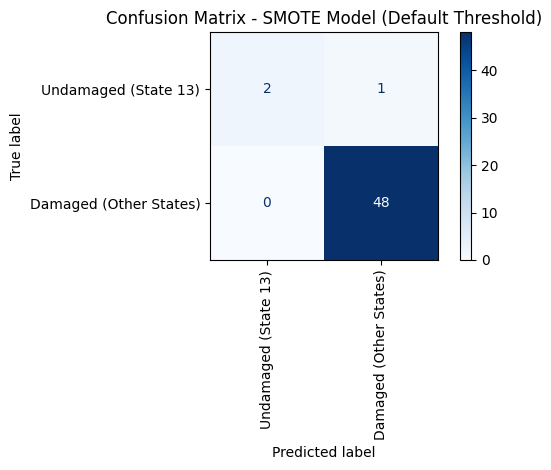

In [19]:
# --- 12. Initial Evaluation (Default Threshold 0.5) ---
print("\nEvaluating model on the original TEST set using default threshold (0.5)...")
y_pred_default = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class (Damaged=1)

evaluate_model(y_test, y_pred_default, y_pred_proba, model_name="SMOTE Model (Default Threshold)")


# Updated model after threshold updation
  Threshold updated based on confidence of the dataset attributes.

In [55]:
best_threshold = 0.5 # Default
best_f1_undamaged = -1

In [56]:
# Test thresholds from 0.05 to 0.95
thresholds_to_test = np.arange(0.05, 1.0, 0.05)
f1_scores_undamaged = []
recall_scores_undamaged = []
precision_scores_undamaged = []


for thresh in thresholds_to_test:
    # Classify based on current threshold
    y_pred_tuned = (y_pred_proba >= thresh).astype(int)

    # Calculate classification report dictionary
    report = classification_report(y_test, y_pred_tuned, target_names=['Undamaged', 'Damaged'], output_dict=True, zero_division=0)

    # Get metrics for the 'Undamaged' class (class 0)
    current_f1 = report['Undamaged']['f1-score']
    current_recall = report['Undamaged']['recall']
    current_precision = report['Undamaged']['precision']

    f1_scores_undamaged.append(current_f1)
    recall_scores_undamaged.append(current_recall)
    precision_scores_undamaged.append(current_precision)

    # Update best threshold
    if current_f1 > best_f1_undamaged:
        best_f1_undamaged = current_f1
        best_threshold = thresh

print(f"\nBest Threshold found: {best_threshold:.2f} (Yields max F1={best_f1_undamaged:.4f} for Undamaged class)")


Best Threshold found: 0.70 (Yields max F1=1.0000 for Undamaged class)


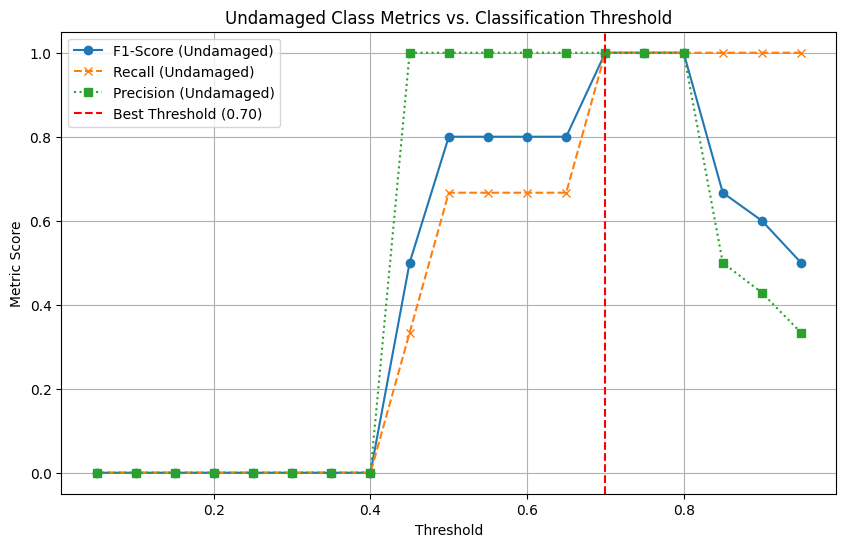


Re-evaluating model using the best threshold (0.70)...

--- Evaluation: SMOTE Model (Threshold = 0.70) ---
Accuracy: 1.0000

Classification Report:
                        precision    recall  f1-score   support

  Undamaged (State 13)       1.00      1.00      1.00         3
Damaged (Other States)       1.00      1.00      1.00        48

              accuracy                           1.00        51
             macro avg       1.00      1.00      1.00        51
          weighted avg       1.00      1.00      1.00        51

ROC AUC Score: 1.0000

Confusion Matrix:
[[ 3  0]
 [ 0 48]]


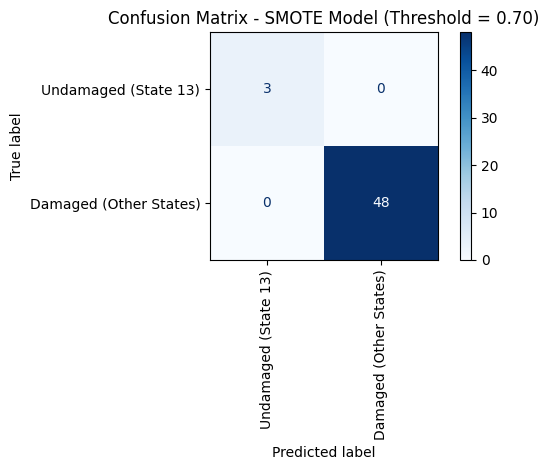

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds_to_test, f1_scores_undamaged, marker='o', label='F1-Score (Undamaged)')
plt.plot(thresholds_to_test, recall_scores_undamaged, marker='x', linestyle='--', label='Recall (Undamaged)')
plt.plot(thresholds_to_test, precision_scores_undamaged, marker='s', linestyle=':', label='Precision (Undamaged)')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Undamaged Class Metrics vs. Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

# --- 14. Final Evaluation (Best Threshold) ---
print(f"\nRe-evaluating model using the best threshold ({best_threshold:.2f})...")
y_pred_best_thresh = (y_pred_proba >= best_threshold).astype(int)
evaluate_model(y_test, y_pred_best_thresh, y_pred_proba, model_name=f"SMOTE Model (Threshold = {best_threshold:.2f})")

Top 15 Most Important Features:
                      Feature  Importance
25  acc1_fft_energy_100_150Hz    0.155536
40                   acc3_std    0.065230
63   acc4_fft_energy_50_100Hz    0.056514
50   acc3_fft_energy_50_100Hz    0.053947
41                   acc3_rms    0.049152
37   acc2_fft_energy_50_100Hz    0.047076
64  acc4_fft_energy_100_150Hz    0.045877
27                   acc2_std    0.043981
43                  acc3_skew    0.041378
38  acc2_fft_energy_100_150Hz    0.039603
34          acc2_fft_peak_amp    0.034628
48          acc3_fft_centroid    0.029751
28                   acc2_rms    0.027895
18              acc1_kurtosis    0.027683
56                  acc4_skew    0.025513


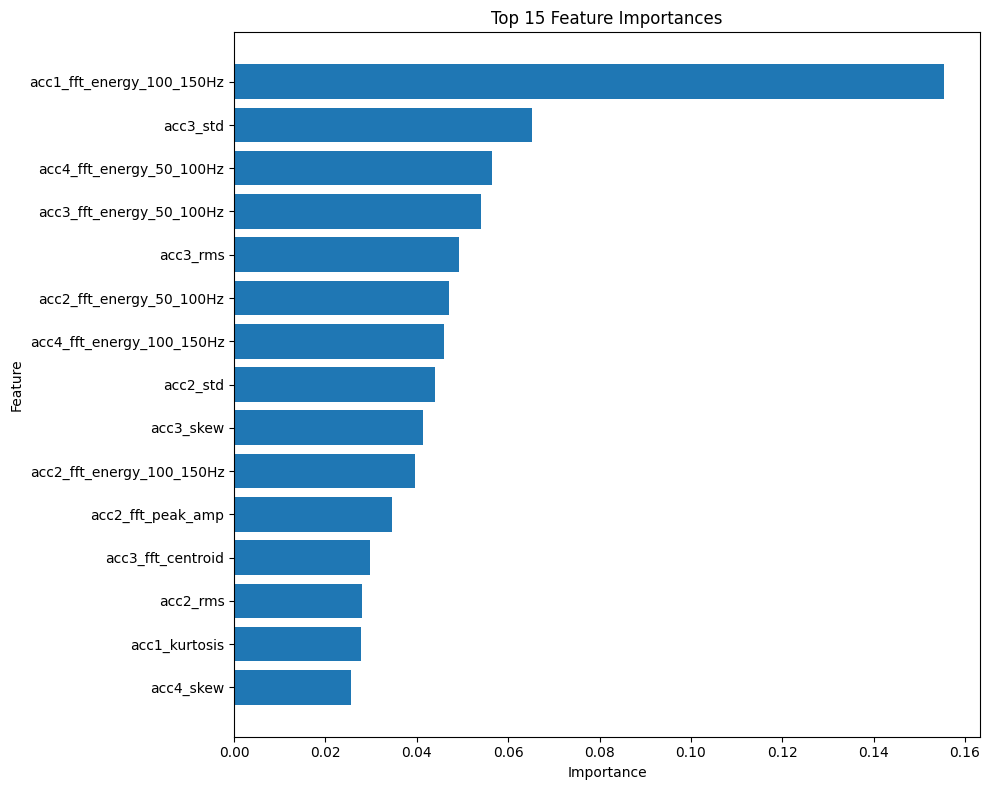

In [58]:
try:
    importances = rf_classifier.feature_importances_
    feature_names = X.columns #original feature names from X before scaling
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("Top 15 Most Important Features:")
    print(feature_importance_df.head(15))

    # Plot top features
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not calculate or plot feature importances: {e}")

#model test temp

In [60]:
import pickle
import os

PIPELINE_FILENAME = '/content/drive/MyDrive/Data_fold/SHM_ML.pkl'

pipeline_components = {
    'model': rf_classifier,
    'scaler': scaler,
    'threshold': best_threshold
}

if 'imputer' in locals() and imputer is not None:
    try:
        _ = imputer.statistics_
        pipeline_components['imputer'] = imputer
        print("Including fitted imputer in the saved file.")
    except AttributeError:
        print("Imputer object exists but appears not fitted. Not including in saved file.")
    except NameError:

         print("Imputer object name not found. Not including in saved file.")
else:
    print("Imputer object not found or not used. Not including in saved file.")


try:
    # Assuming X was the feature DataFrame before scaling
    pipeline_components['feature_names'] = X.columns.tolist()
    print("Including feature names in the saved file.")
except NameError:
    print("Warning: Feature names (X.columns) not found. Not saving feature names.")

try:
    with open(PIPELINE_FILENAME, 'wb') as file: # Open in binary write mode ('wb')
        pickle.dump(pipeline_components, file)
    print(f"Pipeline components successfully saved to: {PIPELINE_FILENAME}")
except Exception as e:
    print(f"Error saving pipeline components to {PIPELINE_FILENAME}: {e}")

Imputer object not found or not used. Not including in saved file.
Including feature names in the saved file.
Pipeline components successfully saved to: /content/drive/MyDrive/Data_fold/SHM_ML.pkl


#Main model save

In [25]:
import pickle
import os

# Define a DIFFERENT output filename for this version
PIPELINE_FILENAME_DEFAULT = '/content/drive/MyDrive/Data_fold/SHL_ML.pkl'

# Create a dictionary to hold the components
pipeline_components = {
    'model': rf_classifier,
    'scaler': scaler,

}

# Check and add imputer if it was used and fitted
if 'imputer' in locals() and imputer is not None:
    try:
        _ = imputer.statistics_
        pipeline_components['imputer'] = imputer
        print("Including fitted imputer in the saved file.")
    except AttributeError:
        print("Imputer object exists but appears not fitted. Not including.")
    except NameError:
         print("Imputer object name not found. Not including.")
else:
    print("Imputer object not found or not used. Not including.")

# Add feature names
try:
    pipeline_components['feature_names'] = X.columns.tolist()
    print("Including feature names in the saved file.")
except NameError:
    print("Warning: Feature names (X.columns) not found. Not saving.")


# Save the dictionary using pickle
try:
    with open(PIPELINE_FILENAME_DEFAULT, 'wb') as file: # Open in binary write mode
        pickle.dump(pipeline_components, file)
    print(f"Pipeline components successfully saved to: {PIPELINE_FILENAME_DEFAULT}")
except Exception as e:
    print(f"Error saving pipeline components to {PIPELINE_FILENAME_DEFAULT}: {e}")

Imputer object not found or not used. Not including.
Including feature names in the saved file.
Pipeline components successfully saved to: /content/drive/MyDrive/Data_fold/SHL_ML.pkl


Loading pipeline from: /content/drive/MyDrive/Data_fold/SHL_ML.pkl
Pipeline loaded successfully.
Pipeline expects 65 features.

Loading new data from: /content/drive/MyDrive/Data_fold/Data_csv/csv#2/data21.csv
New data loaded. Shape: (8192, 7)

Preprocessing new data (Measurement ID, Filtering)...
Identified 1 new measurements.
Filtering applied to new data.

Extracting features from new data...


<ipython-input-26-2692a09f56e6>:135: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df_filtered = new_df.groupby('measurement_id', group_keys=False).apply(
<ipython-input-26-2692a09f56e6>:144: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features_df = new_df_filtered.groupby('measurement_id').apply(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not hav

Features extracted. Shape: (1, 65)

Applying loaded pipeline components...
Reordering features to match training order.
Applying loaded scaler...
Predicting labels using model's default threshold (0.5)...

--- Testing Complete ---
Predictions for new data:
   measurement_id  predicted_label prediction_name
0               0                1         Damaged

Evaluating predictions against true labels...

--- Evaluation Results on New Data (Default Threshold Model) ---
Accuracy: 1.0000

Classification Report:
                        precision    recall  f1-score   support

  Undamaged (State 13)       1.00      1.00      1.00         1

              accuracy                           1.00         1
             macro avg       1.00      1.00      1.00         1
          weighted avg       1.00      1.00      1.00         1


Confusion Matrix:
[[0 0]
 [0 1]]


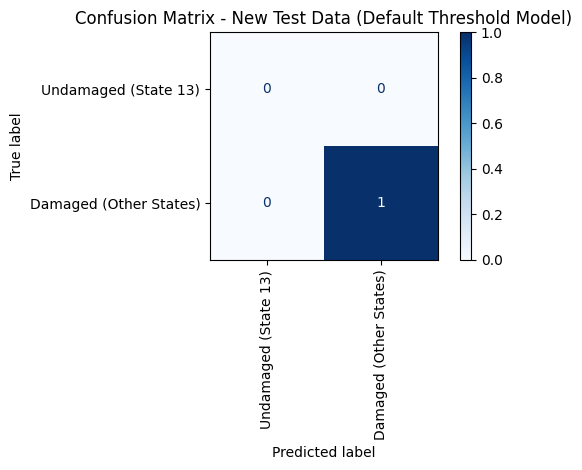

In [26]:
import pickle
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, sosfiltfilt # For filtering
from scipy.stats import skew, kurtosis      # For feature extraction
from scipy.fft import rfft, rfftfreq        # For feature extraction

FS = 322.58
FILTER_LOWCUT = 18.0
FILTER_HIGHCUT = 160.0
FILTER_ORDER = 5
CHANNELS_TO_PROCESS = ['Force', 'acc1', 'acc2', 'acc3', 'acc4']

def apply_filter_to_group(group, channels_to_filter, sos_filter, filter_order):
    # --- PASTE THE EXACT FUNCTION FROM YOUR TRAINING SCRIPT HERE ---
    group = group.copy()
    min_len = 3 * (filter_order + 1)
    for col in channels_to_filter:
        signal = group[col].values
        if len(signal) > min_len:
            try:
                group[col] = sosfiltfilt(sos_filter, signal)
            except Exception as e:
                print(f"Warning: Filtering failed for group, column {col}. Error: {e}. Keeping original.")
        else:
            print(f"Warning: Signal too short ({len(signal)} points) for filtering in group, column {col}. Keeping original.")
    return group

def extract_features(group, channels, fs):
    # --- PASTE THE EXACT FUNCTION FROM YOUR TRAINING SCRIPT HERE ---
    features = {}
    n_points = len(group)
    if n_points <= 1: return pd.Series(features)

    time_values = group['Time'].values
    dt = np.mean(np.diff(time_values)) if n_points > 1 else 1/fs
    if dt <= 0 or np.isnan(dt): dt = 1/fs

    for col in channels:
        signal = group[col].values
        # Time Domain Stats
        features[f'{col}_mean'] = np.mean(signal)
        features[f'{col}_std'] = np.std(signal)
        rms = np.sqrt(np.mean(signal**2))
        features[f'{col}_rms'] = rms
        peak = np.max(np.abs(signal)) if len(signal) > 0 else 0
        features[f'{col}_peak'] = peak
        features[f'{col}_skew'] = skew(signal)
        features[f'{col}_kurtosis'] = kurtosis(signal)
        features[f'{col}_crest_factor'] = peak / rms if rms > 1e-9 else 0
        # Frequency Domain Stats
        if n_points > 1:
            try:
                yf = rfft(signal)
                xf = rfftfreq(n_points, dt)
                yf_abs = np.abs(yf)
                valid_indices = (xf >= 0) & (np.arange(len(xf)) < len(yf_abs))
                xf = xf[valid_indices]
                yf_abs = yf_abs[valid_indices]
                if len(xf) > 0:
                    peak_freq_index = np.argmax(yf_abs)
                    features[f'{col}_fft_peak_freq'] = xf[peak_freq_index]
                    features[f'{col}_fft_peak_amp'] = yf_abs[peak_freq_index]
                    sum_yf_abs = np.sum(yf_abs)
                    features[f'{col}_fft_centroid'] = np.sum(xf * yf_abs) / sum_yf_abs if sum_yf_abs > 1e-9 else 0
                    band1_indices = (xf >= 20) & (xf < 50)
                    features[f'{col}_fft_energy_20_50Hz'] = np.sum(yf_abs[band1_indices]**2) / n_points if n_points > 0 else 0
                    band2_indices = (xf >= 50) & (xf < 100)
                    features[f'{col}_fft_energy_50_100Hz'] = np.sum(yf_abs[band2_indices]**2) / n_points if n_points > 0 else 0
                    band3_indices = (xf >= 100) & (xf < 150)
                    features[f'{col}_fft_energy_100_150Hz'] = np.sum(yf_abs[band3_indices]**2) / n_points if n_points > 0 else 0
                else:
                    features[f'{col}_fft_peak_freq'], features[f'{col}_fft_peak_amp'], features[f'{col}_fft_centroid'] = np.nan, np.nan, np.nan
                    features[f'{col}_fft_energy_20_50Hz'], features[f'{col}_fft_energy_50_100Hz'], features[f'{col}_fft_energy_100_150Hz'] = np.nan, np.nan, np.nan
            except Exception as e:
                print(f"Warning: FFT failed for group, column {col}. Error: {e}. Filling with NaN.")
                features[f'{col}_fft_peak_freq'], features[f'{col}_fft_peak_amp'], features[f'{col}_fft_centroid'] = np.nan, np.nan, np.nan
                features[f'{col}_fft_energy_20_50Hz'], features[f'{col}_fft_energy_50_100Hz'], features[f'{col}_fft_energy_100_150Hz'] = np.nan, np.nan, np.nan
    return pd.Series(features)

# --- Configuration ---
# *** CHANGE THIS FILENAME ***
PIPELINE_FILENAME = '/content/drive/MyDrive/Data_fold/SHL_ML.pkl'
NEW_DATA_FILENAME = '/content/drive/MyDrive/Data_fold/Data_csv/csv#2/data21.csv' # Path to your new data
EXPECTED_NEW_DATA_COLS = ['State', 'Force', 'acc1', 'acc2', 'acc3', 'acc4', 'Time'] # Adjust if needed

# --- 1. Load Saved Pipeline ---
print(f"Loading pipeline from: {PIPELINE_FILENAME}")
if not os.path.exists(PIPELINE_FILENAME):
    print(f"Error: Pipeline file not found at '{PIPELINE_FILENAME}'. Cannot proceed.")
    exit()

try:
    with open(PIPELINE_FILENAME, 'rb') as file:
        pipeline = pickle.load(file)
    # Extract components
    loaded_model = pipeline['model']
    loaded_scaler = pipeline['scaler']
    # --- DO NOT LOAD 'threshold' as it wasn't saved ---
    loaded_imputer = pipeline.get('imputer', None)
    loaded_feature_names = pipeline.get('feature_names', None)
    print("Pipeline loaded successfully.")
    if loaded_imputer: print("Imputer loaded.")
    if loaded_feature_names: print(f"Pipeline expects {len(loaded_feature_names)} features.")

except Exception as e:
    print(f"Error loading pipeline: {e}")
    exit()
new_df = pd.read_csv(NEW_DATA_FILENAME)
# --- 2. Load New Data ---
# [Keep the data loading section as before]
print(f"\nLoading new data from: {NEW_DATA_FILENAME}")
if not os.path.exists(NEW_DATA_FILENAME):
    print(f"Error: New data file not found at '{NEW_DATA_FILENAME}'. Cannot proceed.")
    exit()
try:
    new_df = pd.read_csv(NEW_DATA_FILENAME)
    print(f"New data loaded. Shape: {new_df.shape}")
    if not all(col in new_df.columns for col in EXPECTED_NEW_DATA_COLS):
        print(f"Warning: New data columns ({new_df.columns.tolist()}) do not match expected ({EXPECTED_NEW_DATA_COLS}). Proceeding cautiously.")
except Exception as e:
    print(f"Error loading new data CSV: {e}")
    exit()


# --- 3. Preprocess New Data ---

print("\nPreprocessing new data (Measurement ID, Filtering)...")
new_df['measurement_id'] = (new_df['Time'].diff().fillna(0) < 0).cumsum()
n_new_measurements = new_df['measurement_id'].nunique()
print(f"Identified {n_new_measurements} new measurements.")
sos = butter(FILTER_ORDER, [FILTER_LOWCUT, FILTER_HIGHCUT], btype='band', output='sos', fs=FS)
new_df_filtered = new_df.groupby('measurement_id', group_keys=False).apply(
    apply_filter_to_group,
    channels_to_filter=CHANNELS_TO_PROCESS,
    sos_filter=sos,
    filter_order=FILTER_ORDER
)
print("Filtering applied to new data.")

print("\nExtracting features from new data...")
new_features_df = new_df_filtered.groupby('measurement_id').apply(
    extract_features,
    channels=CHANNELS_TO_PROCESS,
    fs=FS
)
print(f"Features extracted. Shape: {new_features_df.shape}")
new_measurement_ids = new_features_df.index


# --- 4. Apply Saved Pipeline Components ---
print("\nApplying loaded pipeline components...")

if loaded_feature_names is not None:
    print("Reordering features to match training order.")
    try:
        new_features_df = new_features_df[loaded_feature_names]
    except KeyError as e:
        print(f"Error: Features extracted from new data do not match features required by pipeline. Missing: {e}")
        missing_in_new = set(loaded_feature_names) - set(new_features_df.columns)
        extra_in_new = set(new_features_df.columns) - set(loaded_feature_names)
        print(f"Missing in new data: {missing_in_new}")
        print(f"Extra in new data: {extra_in_new}")
        exit()
X_new = new_features_df.values
if np.isinf(X_new).sum() > 0:
    print("Warning: Infinite values found in new features. Replacing with NaN.")
    X_new[np.isinf(X_new)] = np.nan
if loaded_imputer is not None:
    if np.isnan(X_new).sum() > 0:
        print("Applying loaded imputer...")
        try:
            X_new_imputed = loaded_imputer.transform(X_new)
        except Exception as e:
            print(f"Error applying imputer: {e}")
            exit()
    else:
        X_new_imputed = X_new
        print("No NaNs found in new features, skipping imputation step.")
else:
    X_new_imputed = X_new
    if np.isnan(X_new).sum() > 0:
        print("Warning: NaNs found in new features, but no imputer was loaded.")

# [Keep scaler application as before]
print("Applying loaded scaler...")
try:
    X_new_scaled = loaded_scaler.transform(X_new_imputed)
except ValueError as e:
    print(f"Error applying scaler: {e}")
    print(f"   Expected {loaded_scaler.n_features_in_} features, got {X_new_imputed.shape[1]}.")
    exit()
except Exception as e:
    print(f"Error applying scaler: {e}")
    exit()


# --- 5. Make Predictions using Default Threshold ---

print("Predicting labels using model's default threshold (0.5)...")
try:
    final_predictions = loaded_model.predict(X_new_scaled)
except Exception as e:
    print(f"Error during model prediction: {e}")
    exit()

# --- 6. Output/Evaluate Results ---
print("\n--- Testing Complete ---")
# Create results DataFrame (no probability needed unless desired for inspection)
results_df = pd.DataFrame({
    'measurement_id': new_measurement_ids,
    'predicted_label': final_predictions # Direct 0/1 labels
})
results_df['prediction_name'] = results_df['predicted_label'].map({0: 'Undamaged', 1: 'Damaged'})
print("Predictions for new data:")
print(results_df)


TRUE_LABELS_AVAILABLE = 'State' in new_df.columns
if TRUE_LABELS_AVAILABLE:
    print("\nEvaluating predictions against true labels...")
    true_states = new_df.groupby('measurement_id')['State'].first()
    true_states = true_states.reindex(results_df['measurement_id'])
    TARGET_STATE = 13
    true_labels = true_states.apply(lambda x: 0 if x == TARGET_STATE else 1).values # Use .values to get numpy array

    if len(true_labels) == len(final_predictions):
        from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
        import matplotlib.pyplot as plt

        print("\n--- Evaluation Results on New Data (Default Threshold Model) ---")
        accuracy = accuracy_score(true_labels, final_predictions)
        print(f"Accuracy: {accuracy:.4f}")
        target_names = ['Undamaged (State 13)', 'Damaged (Other States)']
        print("\nClassification Report:")
        print(classification_report(true_labels, final_predictions, target_names=target_names, labels=np.unique(true_labels), zero_division=0))
        print("\nConfusion Matrix:")
        try:
            cm = confusion_matrix(true_labels, final_predictions, labels=[0, 1])
            print(cm)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
            disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
            plt.title('Confusion Matrix - New Test Data (Default Threshold Model)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot confusion matrix: {e}")
    else:
        print("\nError: Could not align true labels with predictions for evaluation.")
else:
    print("\nTrue labels for new data not readily available. Skipping quantitative evaluation.")